In [84]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import plotly.graph_objects as go
import plotly.express as px

In [ ]:
!pip install yfinance

In [54]:
import yfinance as yf

prices = yf.download('AMZN','2018-07-01','2022-06-30')
prices.head(3)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-02,84.135002,85.694504,83.903000,85.689003,85.689003,63714000
2018-07-03,86.197998,86.250000,84.624001,84.697998,84.697998,43546000
2018-07-05,85.268997,85.534500,84.107498,84.986504,84.986504,59662000


In [55]:
figure = go.Figure(data=[go.Candlestick(x=prices.index,
                                        open=prices['Open'], high=prices['High'],
                                        low=prices['Low'], close=prices['Close'])])
figure.update_layout(title = "Amazon Stock Price Analysis",
                     xaxis_rangeslider_visible = False)
figure.show()

In [56]:
prices.index = prices.index.to_period(freq='d')
price = prices['Adj Close']
ret = price.pct_change() 
ret = ret.dropna()
ret

Date
2018-07-03   -0.011565
2018-07-05    0.003406
2018-07-06    0.006413
2018-07-09    0.016596
2018-07-10    0.002329
                ...   
2022-06-23    0.032033
2022-06-24    0.035752
2022-06-27   -0.027821
2022-06-28   -0.051404
2022-06-29    0.014153
Freq: D, Name: Adj Close, Length: 1005, dtype: float64

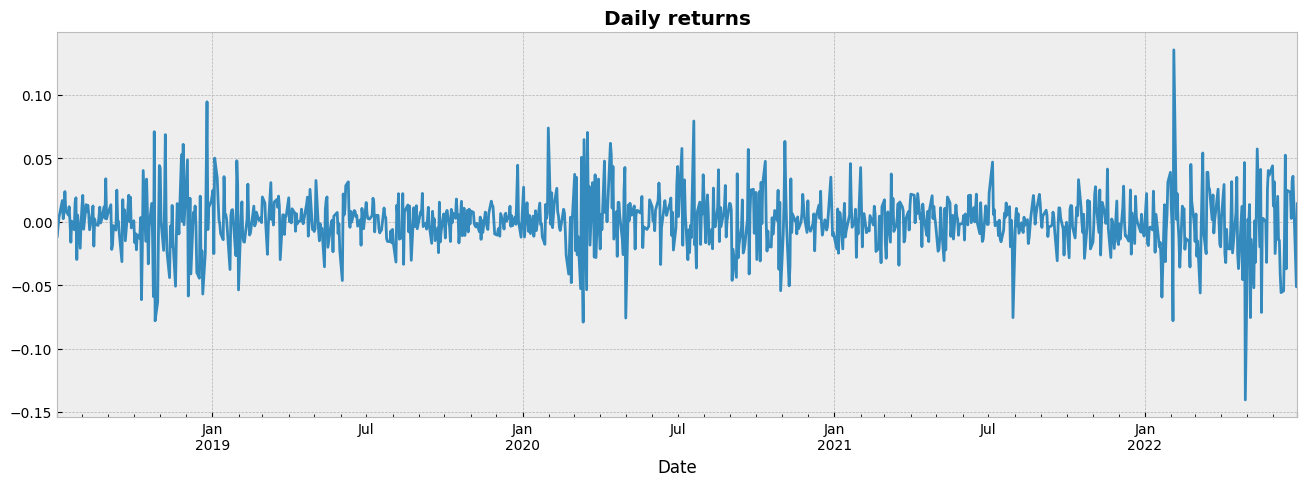

In [57]:
fig = plt.figure(figsize=(16, 5))
ret.plot()
plt.title("Daily returns", weight="bold")
plt.show()

## Value-at-Risk
Будем рассчитывать для доверительного интервала 95%.

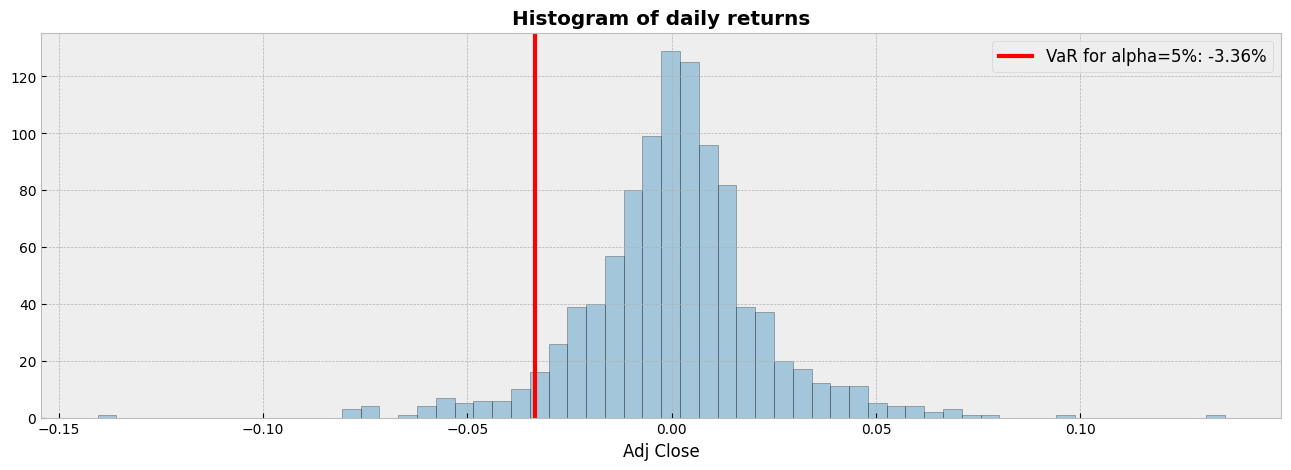

In [12]:
alpha = 0.05

VaR_HS_05 = ret.quantile(0.05)
fig = plt.figure(figsize=(16, 5))
sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.axvline(x=VaR_HS_05, linewidth=3, color="r")
plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05)], fontsize=12)
plt.show()

## Различные подходы


### **1. Модель GARCH с константным средним, FIGARCH(1,1,2) и распределением Стьюдента для остатков**

Проверим является ли распределение доходности t-распределением Стьюдента.

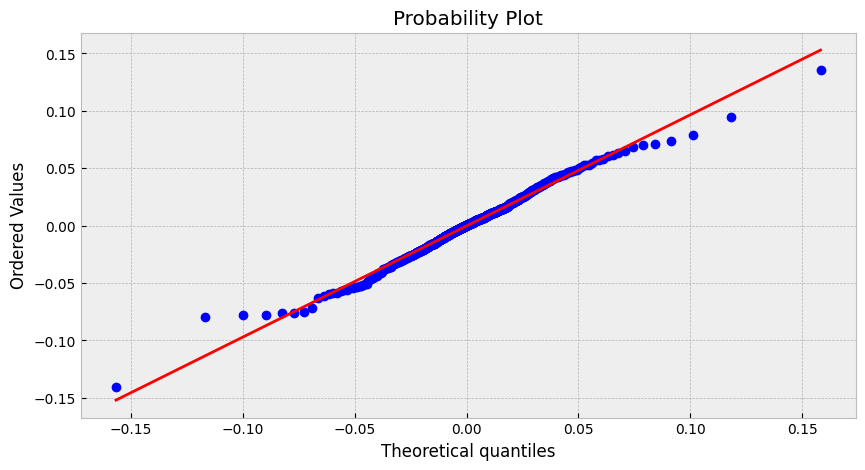

In [13]:
import scipy.stats as ss

params_t = ss.t.fit(ret)
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.t(*params_t), plot=plt)
plt.show()

Видим, что нет.

In [ ]:
!pip install arch

In [58]:
import arch
from arch import arch_model 

model_1 = arch_model(100*ret, mean='Constant', vol='FIGARCH', p=1, q=1, power=2.0, dist='t')
res = model_1.fit()
print(res)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4462.3295583689805
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2353.5457131000157
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2919.4493781679275
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2082.507405705701
Iteration:      5,   Func. Count:     44,   Neg. LLF: 2092.0664177078975
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2068.1013603633287
Iteration:      7,   Func. Count:     60,   Neg. LLF: 2076.2238450340774
Iteration:      8,   Func. Count:     68,   Neg. LLF: 2066.483639504339
Iteration:      9,   Func. Count:     76,   Neg. LLF: 2066.4273150973054
Iteration:     10,   Func. Count:     83,   Neg. LLF: 2066.426704673395
Iteration:     11,   Func. Count:     90,   Neg. LLF: 2066.4266971247157
Iteration:     12,   Func. Count:     96,   Neg. LLF: 2066.4266971247257
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2066.4266971247157
            Iterat

In [60]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, 
                    vol='Garch', p=1, o=1, q=1, 
                    dist=dist) 
    res = am.fit(update_freq=0, disp='off')
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [107]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)

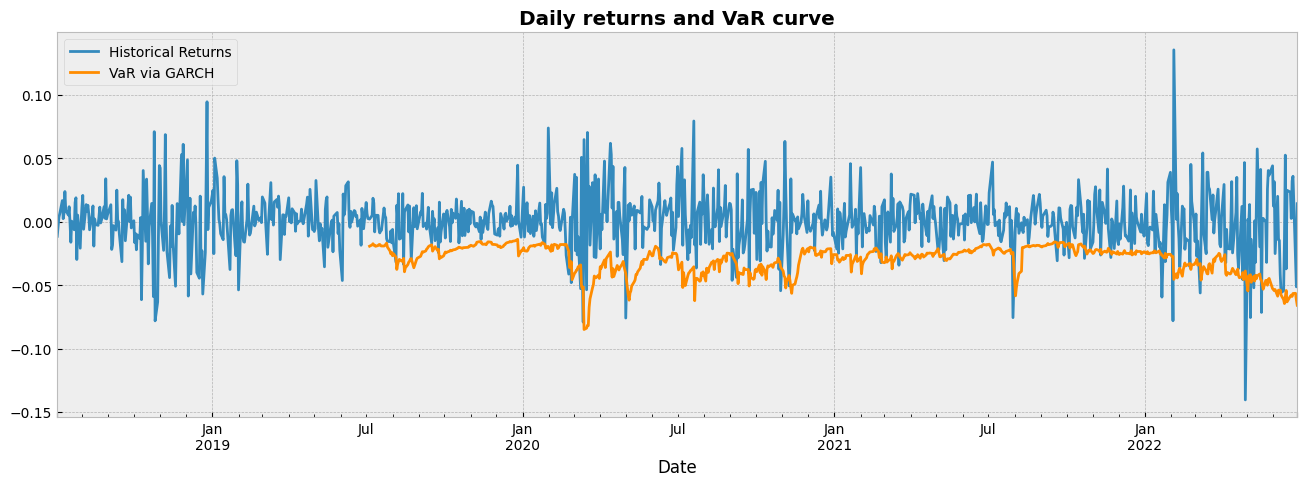

In [108]:
fig = plt.figure(figsize=(16, 5))
ret.plot()
VaR_garch.plot(color='darkorange')
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(['Historical Returns',
            'VaR via GARCH'])
plt.show()

### **2. Обратное Гауссовское распределение**

In [65]:
import scipy.stats as ss

params_ng = ss.norminvgauss.fit(ret)
ng_alpha, ng_beta, ng_mu, ng_lambda = params_ng

VaR_ng = ss.norminvgauss.ppf(alpha, ng_alpha, ng_beta, ng_mu, ng_lambda)

print('Estimated parameters: skewness={:.2f}, scale={:.2f}, mean={:.2f}, tail heaviness={:.2f}.'.format(ng_alpha, ng_beta, ng_mu, ng_lambda))
print('Value-at-Risk: {:.2f}%.'.format(100*VaR_ng))

Estimated parameters: skewness=0.56, scale=-0.03, mean=0.00, tail heaviness=0.02.
Value-at-Risk: -3.47%.


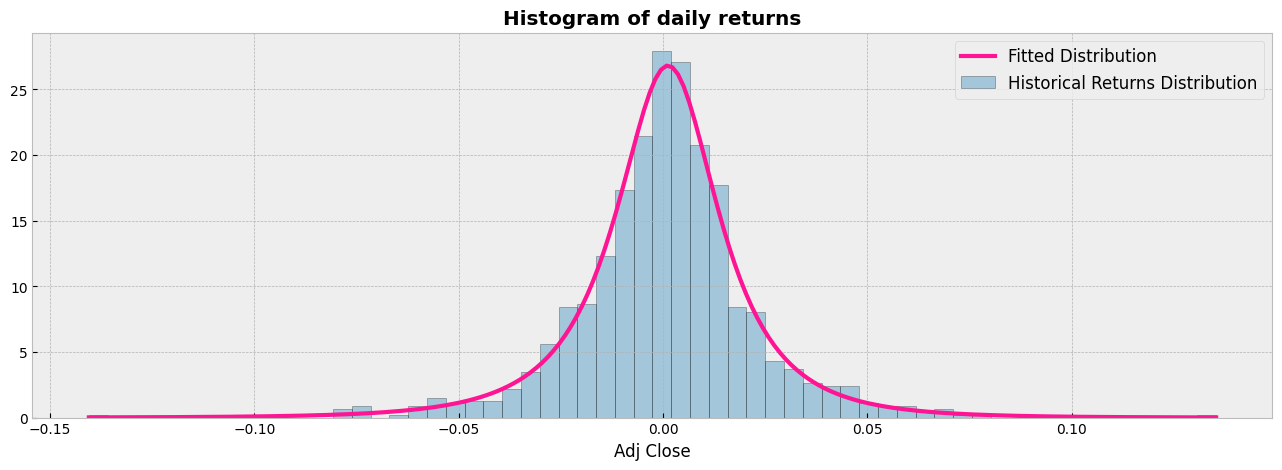

In [88]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.norminvgauss.pdf(x, *params_ng)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3,color='deeppink')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)

plt.show()

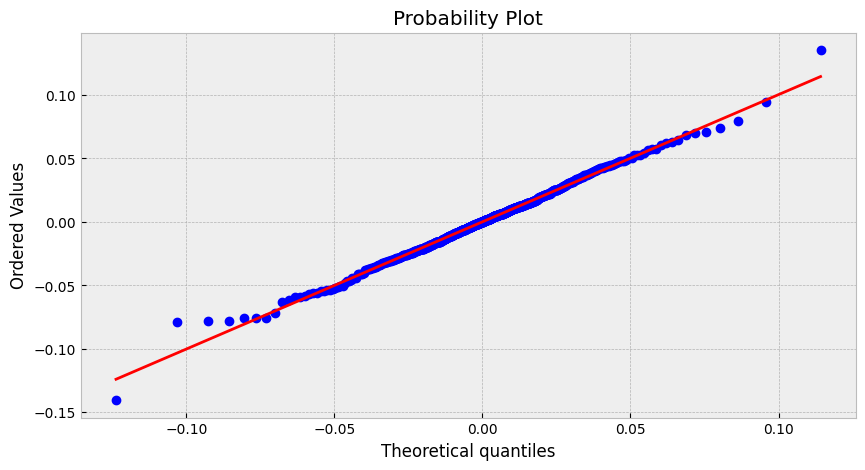

In [87]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.norminvgauss(*params_ng), plot=plt)
plt.show()

In [70]:
def calculate_VaR_ng(ret, alpha=0.05):
    params_ng = ss.norminvgauss.fit(ret)
    return ss.norminvgauss.ppf(alpha, *params_ng)

In [71]:
VaR_ng = calc_VaR(ret, calculate_VaR_ng, L_history=252, level=alpha)

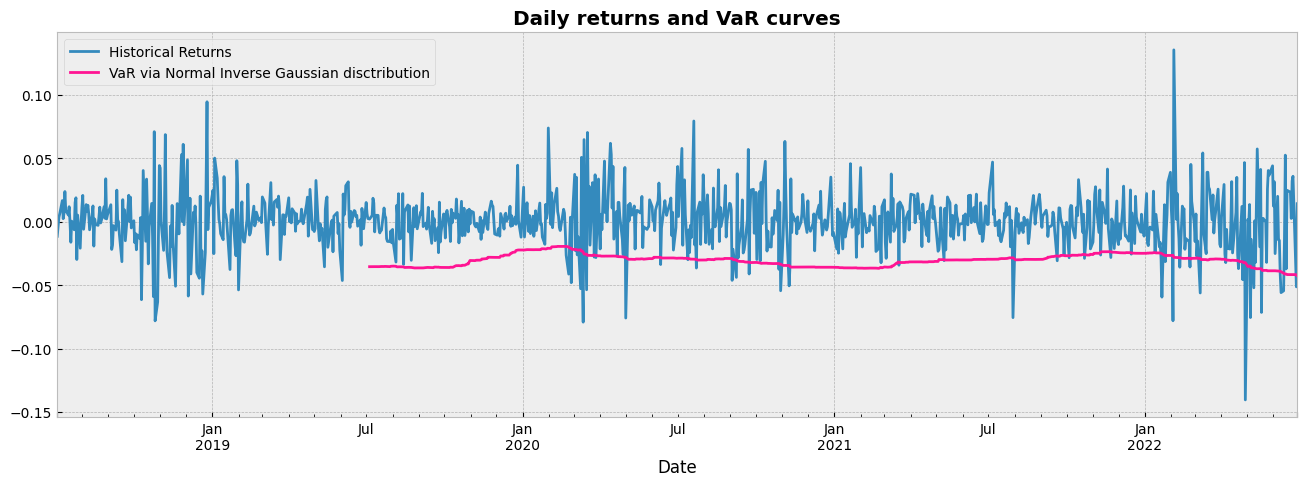

In [90]:
fig = plt.figure(figsize=(16, 5))
ret.plot()
VaR_ng.plot(color='deeppink')
plt.title("Daily returns and VaR curves", weight="bold")
plt.legend(['Historical Returns',
            'VaR via Normal Inverse Gaussian disctribution'])
plt.show()

### **3. Комбинация GARCH и EVT**

In [97]:
model_3 = arch_model(100 * ret,
                    mean='Constant', lags=1,
                    vol='Garch', p=2, o=2, q=2, 
                    dist='skewstudent')

res = model_3.fit(disp='off')

# получаем стандартизированные остатки
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()


# предсказываем средднее и десперсию на один шаг вперед
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# получаем предсказанные условные доходности
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100


# считаем VaR как квантиль
VaR_ge = conditional_sr.quantile(alpha)

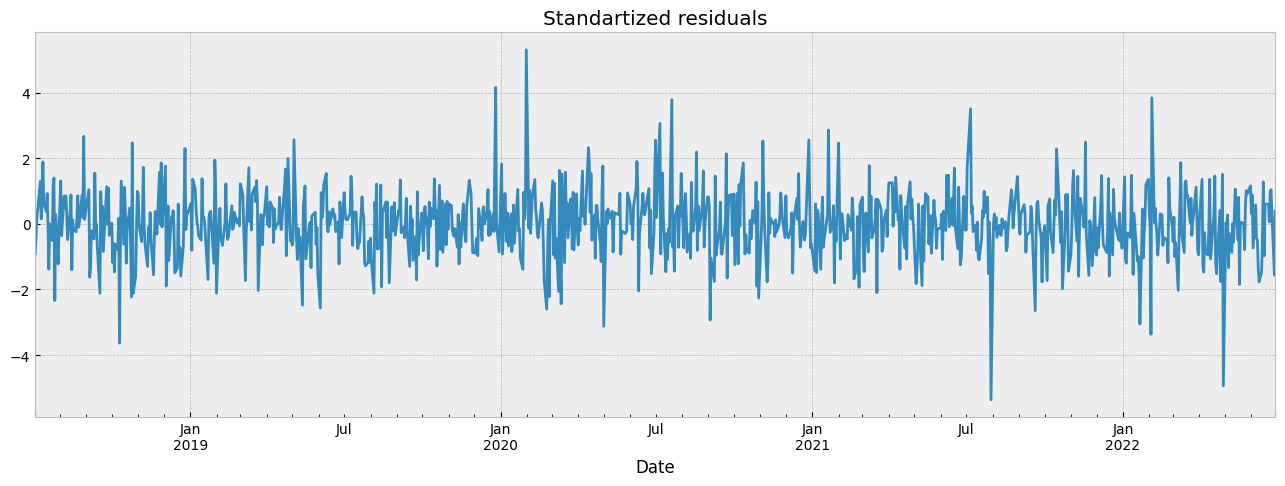

In [98]:
fig = plt.figure(figsize=(16, 5))
stand_residuals.plot()
plt.title('Standartized residuals')
plt.show()

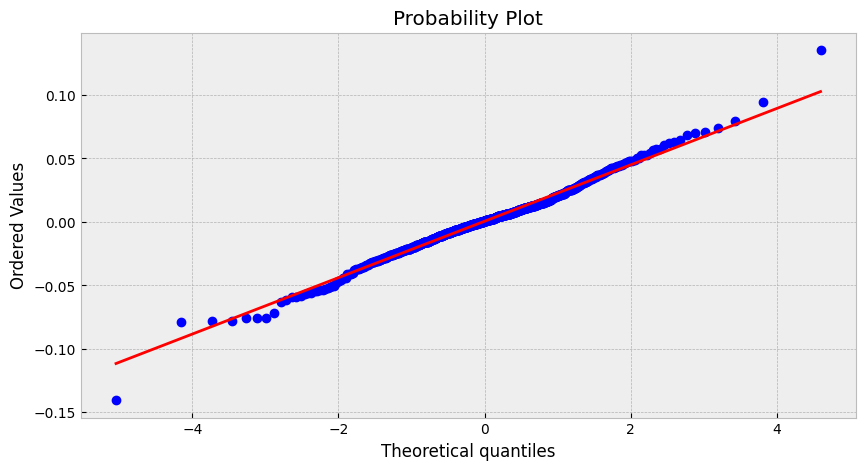

In [19]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=model_3.distribution, sparams=(res.params[-2:],), plot=plt)
plt.show()

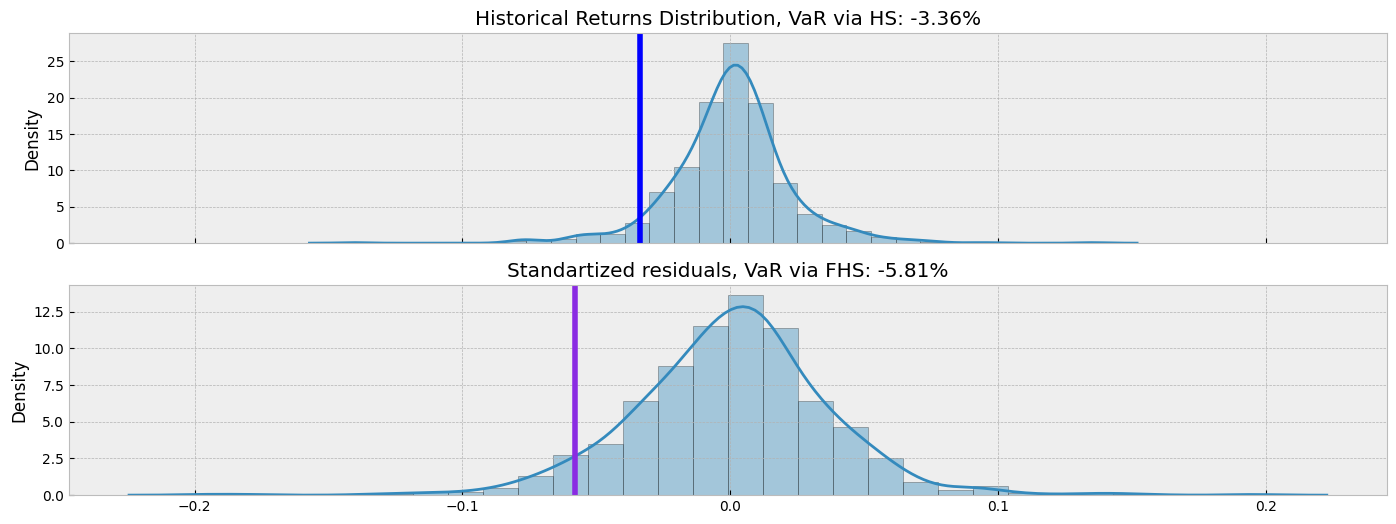

In [100]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_05))
ax[0].axvline(x=VaR_HS_05, linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_ge))
ax[1].axvline(x=VaR_ge, linewidth=4, color="blueviolet")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

In [101]:
def calculate_VaR_ge(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # получаем стандартизированные остатки
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


   # предсказываем среднее и десперсию на один шаг вперед
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем предсказанные условные доходности
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    u = conditional_sr.quantile(0.2)
    ret_tail = conditional_sr[conditional_sr <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    VaR_ge = u - scale / c * ((alpha/(conditional_sr <= u).mean())**(-c) - 1)

    return VaR_ge


In [102]:
VaR_ge = calc_VaR(ret, calculate_VaR_ge, L_history=252, level=alpha)

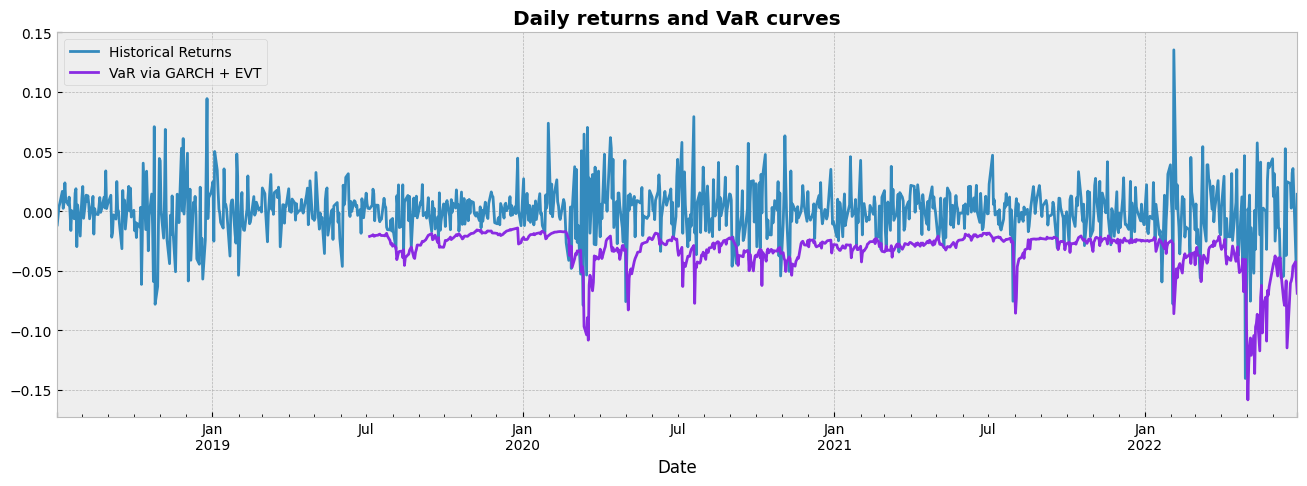

In [105]:
fig = plt.figure(figsize=(16, 5))
ret.plot()
VaR_ge.plot(color="blueviolet")

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via GARCH + EVT'])

plt.show()

## Бектестирование VaR

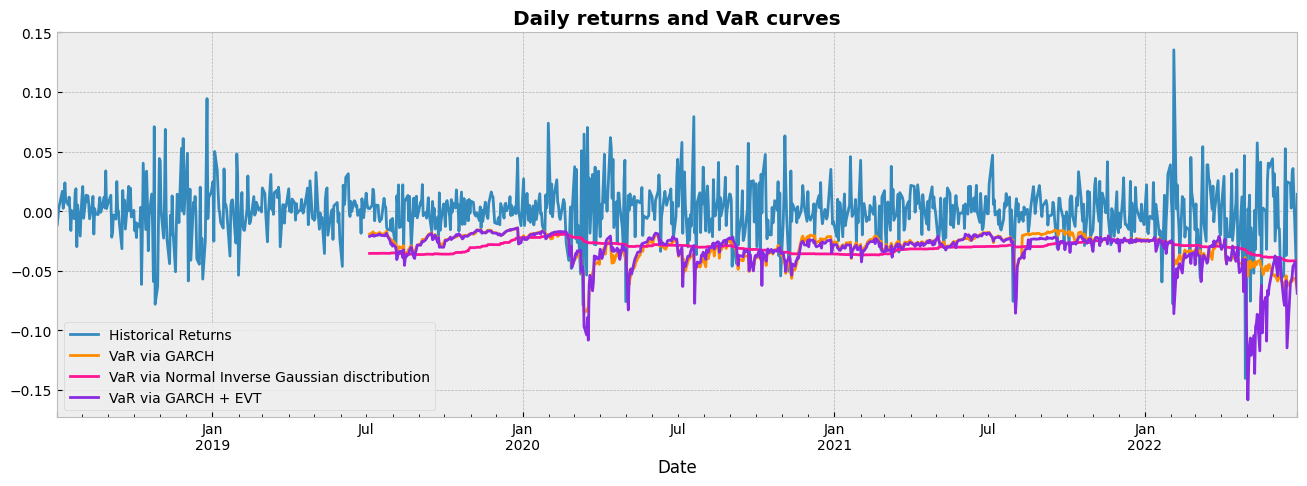

In [106]:
fig = plt.figure(figsize=(16, 5))
ret.plot()
VaR_garch.plot(color='darkorange')
VaR_ng.plot(color='deeppink')
VaR_ge.plot(color="blueviolet")

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via GARCH',
            'VaR via Normal Inverse Gaussian disctribution',
            'VaR via GARCH + EVT'])

plt.show()

In [113]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_conservative)} zone\n')

In [114]:
backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_ng, 1-alpha)
backtest_VaR(ret, VaR_ge, 1-alpha)

Backtesting calculate_VaR_garch:
The proportion of hits is 5.98% instead of expected 5.0%
Two-sided p-val 0.21, one-sided: 0.127
green zone

Backtesting calculate_VaR_ng:
The proportion of hits is 6.51% instead of expected 5.0%
Two-sided p-val 0.0652, one-sided: 0.0388
yellow zone

Backtesting calculate_VaR_ge:
The proportion of hits is 5.58% instead of expected 5.0%
Two-sided p-val 0.451, one-sided: 0.255
green zone



**Выводы:** Для оценки тестом световора выбран односторонний критерий для более строгой оценки. Первая и третья модель попадают в зеленую зону, следовательно их можем уверенно использовать.

H0 для одностороннего теста: Ожидаемый процент пробоев меньше уровня значимоти. 

H0 для двухстороннего теста: Уровень пробоев = alpha.

Наименьший процент пробоев у 3 модели (Комбинация GARCH и EVT). Также ее значения p-value для тестов показывает наилучший результат.